<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/L6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch computer vision

Coputer vision libaries in PyTorch

* `torchvision` - base domain library
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained models
* `otrchvision.transforms` - functions for manipulating your vision data from images in to tensors
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Create a Python iterable over a dataset

In [5]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121


In [6]:
# Utils
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [7]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Getting a dataset

The data set we use here is FashionMNIST from `torchvision.datasets`

In [8]:
train_data = datasets.FashionMNIST(
  root="data", # where to download it
  train=True, # do we want the training data set
  transform=ToTensor(), # transform it
  download=True, # download or not?
  target_transform=None # keep the labels as it is
)

test_data = datasets.FashionMNIST(
  root="data",
  train=False,
  transform=ToTensor(),
  download=True,
  target_transform=None # keep the labels as it is
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 194kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.64MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.3MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [9]:
len(train_data), len(test_data)

(60000, 10000)

In [10]:
# chack the 1. tensor and labels
img, label = train_data[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [11]:
# class names AKA the labels
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [12]:
# map the classes to labels
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [13]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [14]:
# chack the shapes
print(f"Train image shape: {img.shape} -> [color_channels, height, width]") # this is only 1 color cjanel becous the image is black and white!
print(f"Image label: {label} -> [class_index] => { class_names[label]}")

Train image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: 9 -> [class_index] => Ankle boot


Image shape: torch.Size([1, 28, 28])
Image label: 9 -> Ankle boot


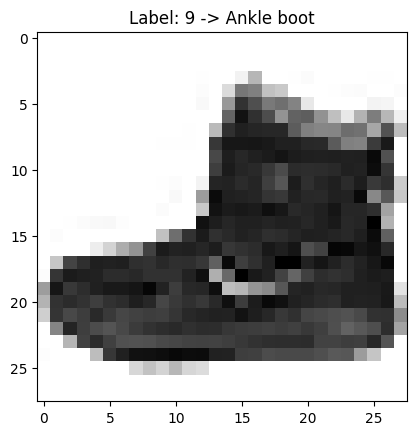

In [15]:
# Visualizing the data

image, label = train_data[0]
print(f"Image shape: {image.shape}")
print(f"Image label: {label} -> {class_names[label]}")
plt.imshow(image.squeeze(), cmap="binary")
plt.title(f"Label: {label} -> {class_names[label]}")
plt.show()

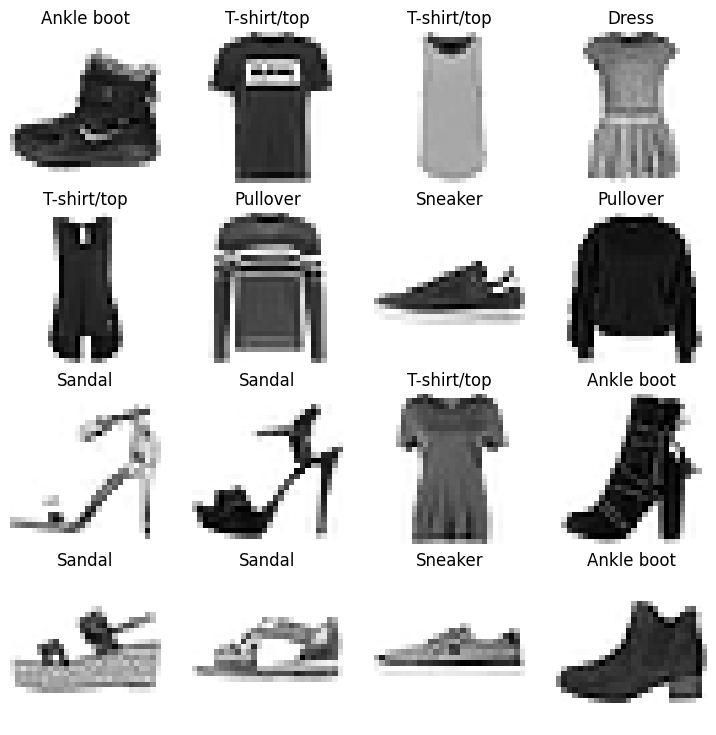

In [16]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(rows * cols):
  image, label = train_data[i]
  fig.add_subplot
  plt.subplot(rows, cols, i+1)
  plt.imshow(image.squeeze(), cmap="binary")
  plt.title(f"{class_names[label]}")
  plt.axis(False)

In [17]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Data loder turn the data in to itarable

We can turn the data in to mini-batches



In [18]:
# Set up hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.1
RANDOM_SEED = 42
INPUT_SHAPE = (28, 28)
OUTPUT_SHAPE = len(class_names) # dynamicly assigne to the class names
HIDDEN_UNITS = 128
DROPOUT_RATE = 0.2


In [19]:
# Prepare DataLoder

train_dataloader = torch.utils.data.DataLoader(
  dataset=train_data,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=1,
  pin_memory=True
)

test_dataloader = torch.utils.data.DataLoader(
  dataset=test_data,
  batch_size=BATCH_SIZE,
  shuffle=False, # keep it in order, better for testing
  num_workers=1,
  pin_memory=True
)

len(train_dataloader)
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

# Batching data

* 1 . ML we can have a lot of data to look at and computer memory is limited, so we use data batching to break down the training data in to reasonable size, at the time.
* 2 . It give more chanse to the model to learn form th data

In [20]:
# Check out what is insode the dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

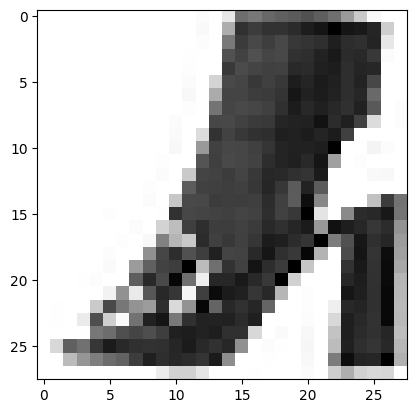

In [21]:
# Show a sample
torch.manual_seed(RANDOM_SEED)
random_idx = torch.randint(low=0, high=len(train_features_batch), size=(1,)).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="binary")

# Bild a baseline model

Base model is someting you will try to build up on after subsequent experiments.
Start simple and add complexity if neceserry.

In [22]:
# Create a flatten layer

flatten_layer = nn.Flatten()

# get a single sample
x = train_features_batch[0]
print(x.shape)
x = flatten_layer(x)
print(x.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [23]:
# Model
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
    super().__init__()
    #print(f"Input shape: {input_shape}")
    self.layer_stack = nn.Sequential(
      nn.Flatten(), # the x input shape torch.Size([1, 28, 28]) will become 28 * 28 = 784 <-- = input_shape. The flaten methid achive it!
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    #print(f"x = {x.shape}")
    return self.layer_stack(x)

In [24]:
torch.manual_seed(RANDOM_SEED)
model_0 = FashionMNISTModel(
  input_shape=INPUT_SHAPE[0] * INPUT_SHAPE[1], # input shape is 28 * 28 as we flaten the entire images in to 1 dimentiponal array
  output_shape=OUTPUT_SHAPE,
  hidden_units=HIDDEN_UNITS
).to(device)

model_0.layer_stack

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
# Make a dry run, just to see the output with no training
dummy_x = torch.randn(size=(1, 28, 28)).to(device)
print(dummy_x.shape)
dummy_y_logits = model_0(dummy_x)
dummy_y_logits, dummy_y_logits.shape

torch.Size([1, 28, 28])


(tensor([[-0.0612, -0.1200,  0.0552,  0.1033,  0.0752, -0.1985, -0.1174, -0.0163,
           0.0829,  0.0507]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([1, 10]))

In [26]:
# Set up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
  params=model_0.parameters(),
  lr=LEARNING_RATE
)

# Create a function to time the experiments

Two of the main thing you often want to track are:
1. Model's performance (loss and accuracy ...etc)
2. How fast it runs

In [27]:
from timeit import default_timer as timer

def print_train_time(
    start: float,
    end: float,
    device: torch.device = device):
  """ Print the difference between sthe start and the end time """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


# How to use it?

start_time = timer()
# some code...
end_time = timer()

print_train_time(start_time, end_time, device=device)

Train time on cuda: 0.000 seconds


2.5782999998114065e-05

# Create a treaning loop

1. Loop over epochs.
2. Loop over training batches, perform training steps, calculate the train loss `per batch`
3. Loop over testing batches, perform testing steps, calculate the test loss `per batch`
4. Print out the logs
5. Time it all

In [28]:
# Use progress bar
from tqdm.auto import tqdm

In [29]:
# set seed to be consistent
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)


# start timer
start_time = timer()

# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
  model_0.train()

  # Training
  train_loss = 0

  # Train on batches
  for batch, (train_features_batch, train_labels_batch) in enumerate(train_dataloader):
    train_features_batch, train_labels_batch = train_features_batch.to(device), train_labels_batch.to(device)
    y_pred = model_0(train_features_batch)
    loss = loss_fn(y_pred, train_labels_batch)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at: {batch * len(train_features_batch)}/{len(train_dataloader.dataset)} sample.")

  # calculate loss / epoch
  train_loss /= len(train_dataloader)

  # testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for test_features_batch, test_labels_batch in test_dataloader:
      test_features_batch, test_labels_batch = test_features_batch.to(device), test_labels_batch.to(device)
      test_pred = model_0(test_features_batch)
      test_loss += loss_fn(test_pred, test_labels_batch)
      test_acc += accuracy_fn(y_true = test_labels_batch , y_pred = test_pred.argmax(dim=1)) # test_pred.argmax(dim=1) get the highest value INDEX

    # calculate accuracy and loss / test batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    print(f"Train time on {device}: {end_time-start_time:.3f} seconds")


# end timer
end_time = timer()

# print the train time
print_train_time(start_time, end_time, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at: 0/60000 sample.
Looked at: 12800/60000 sample.
Looked at: 25600/60000 sample.
Looked at: 38400/60000 sample.
Looked at: 51200/60000 sample.
Train loss: 0.5967 | Test loss: 0.4451 | Test acc: 83.5863
Train time on cuda: -0.132 seconds
Looked at: 0/60000 sample.
Looked at: 12800/60000 sample.
Looked at: 25600/60000 sample.
Looked at: 38400/60000 sample.
Looked at: 51200/60000 sample.
Train loss: 0.4090 | Test loss: 0.4198 | Test acc: 84.8143
Train time on cuda: -0.132 seconds
Looked at: 0/60000 sample.
Looked at: 12800/60000 sample.
Looked at: 25600/60000 sample.
Looked at: 38400/60000 sample.
Looked at: 51200/60000 sample.
Train loss: 0.3655 | Test loss: 0.3852 | Test acc: 86.0024
Train time on cuda: -0.132 seconds
Looked at: 0/60000 sample.
Looked at: 12800/60000 sample.
Looked at: 25600/60000 sample.
Looked at: 38400/60000 sample.
Looked at: 51200/60000 sample.
Train loss: 0.3390 | Test loss: 0.3692 | Test acc: 86.6414
Train time on cuda: -0.132 seconds
Looked at: 0/60000 s

153.79377333899998

# Make predictions and get model_0 results

In [35]:
# set seed to be consistent
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

def eval_model(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  """ Return a dictionary containing the results of the model predictions """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the avarage loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__, # This only work for model created with a class
      "model_loss": loss.item(),
      "model_acc": acc
      }

In [36]:
model_0_results = eval_model(
  model=model_0,
  data_loader=test_dataloader,
  loss_fn=loss_fn,
  accuracy_fn=accuracy_fn
)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3314617872238159,
 'model_acc': 88.03913738019169}